In [1]:
!unzip -O 'cp949' "2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803.zip"

Archive:  2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803.zip
   creating: 2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/01_제공데이터/
  inflating: 2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/01_제공데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx  
   creating: 2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/02_평가데이터/
  inflating: 2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/02_평가데이터/2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_평가데이터_210803.xlsx  


In [2]:
## https://dacon.io/competitions/official/235689/overview/description

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## knn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

base='2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/'
train_folder='01_제공데이터/'

data=pd.read_excel(base+train_folder+'2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx')

cols=['홍수사상번호','연','월','일','시간','유입량']

for i in range(1,7):
    prefix=f'데이터집단{i}_'
    cols.append(prefix+'유역평균강수')
    cols.append(prefix+'강우(A지역)')
    cols.append(prefix+'강우(B지역)')
    cols.append(prefix+'강우(C지역)')
    cols.append(prefix+'강우(D지역)')
    cols.append(prefix+'수위(E지역)')
    cols.append(prefix+'수위(B지역)')

data=data.drop(0).reset_index(drop=True)
data.columns=cols

for idx,col in enumerate(cols):
    if idx<5:
        data[col]=data[col].astype(int)
    else:
        data[col]=data[col].astype(float)    
        
from datetime import datetime,timedelta

data['time']=data.apply(lambda row:datetime(year=int(row['연']),month=int(row['월']),day=int(row['일'])),axis=1)
data['time']=data.apply(lambda row:row['time']+timedelta(hours=row['시간']),axis=1)

train=data.iloc[:2891]
test=data.iloc[2891:]

submit=test[['홍수사상번호','연','월','일','시간']]
submit['유입량']=0

train=train.drop(['홍수사상번호','연','월','일','시간','time'],axis=1)
test=test.drop(['유입량','홍수사상번호','연','월','일','시간','time'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
X=train.drop(['유입량'],axis=1).values

sc=StandardScaler()
X=sc.fit_transform(X)
test=sc.transform(test.values)
y=train['유입량'].values

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train.shape : {x_train.shape}, x_valid.shape : {x_test.shape}")
print(f"y_train.shape : {y_train.shape}, y_valid.shape : {y_test.shape}")

X_train.shape : (2312, 42), x_valid.shape : (579, 42)
y_train.shape : (2312,), y_valid.shape : (579,)


In [5]:
rmse_val = [] #to store rmse values for different k
for K in range(1,21):
    model = KNeighborsRegressor(n_neighbors = K,weights = "distance")

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 232.6547230678413
RMSE value for k=  2 is: 168.48065966949332
RMSE value for k=  3 is: 202.34728712128796
RMSE value for k=  4 is: 209.50938558784125
RMSE value for k=  5 is: 230.15041135958438
RMSE value for k=  6 is: 248.26105408410854
RMSE value for k=  7 is: 272.3957384561186
RMSE value for k=  8 is: 284.5483425465039
RMSE value for k=  9 is: 295.4623439528626
RMSE value for k=  10 is: 309.44378892115213
RMSE value for k=  11 is: 325.89172374713263
RMSE value for k=  12 is: 338.0096922310833
RMSE value for k=  13 is: 348.27382874485653
RMSE value for k=  14 is: 355.95678130789753
RMSE value for k=  15 is: 369.8849943093332
RMSE value for k=  16 is: 387.19862729246853
RMSE value for k=  17 is: 399.07857906009656
RMSE value for k=  18 is: 413.4873985519579
RMSE value for k=  19 is: 423.34114813536615
RMSE value for k=  20 is: 434.75460019016515


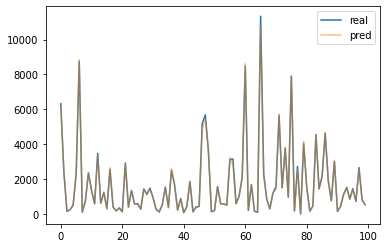

In [6]:
knn_model=KNeighborsRegressor(n_neighbors = 2)

knn_model.fit(X,y)

pred=knn_model.predict(x_test)

plt.figure()
plt.plot(y_test[:100],label='real')
plt.plot(pred[:100],label='pred', alpha=0.5)
plt.legend()
plt.show()

In [7]:
knn_model.fit(X,y)

pred=knn_model.predict(test)
submit_knn=submit.copy()
submit_knn['유입량']=pred
submit_knn.head()

,홍수사상번호,연,월,일,시간,유입량
2891,26,2018,7,1,6,167.788341
2892,26,2018,7,1,7,167.788341
2893,26,2018,7,1,8,159.991283
2894,26,2018,7,1,9,168.820359
2895,26,2018,7,1,10,214.664678


In [8]:
## 다시

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

base='2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_데이터_210803/'
train_folder='01_제공데이터/'

data=pd.read_excel(base+train_folder+'2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210803.xlsx')

cols=['홍수사상번호','연','월','일','시간','유입량']

for i in range(1,7):
    prefix=f'데이터집단{i}_'
    cols.append(prefix+'유역평균강수')
    cols.append(prefix+'강우(A지역)')
    cols.append(prefix+'강우(B지역)')
    cols.append(prefix+'강우(C지역)')
    cols.append(prefix+'강우(D지역)')
    cols.append(prefix+'수위(E지역)')
    cols.append(prefix+'수위(B지역)')

data=data.drop(0).reset_index(drop=True)
data.columns=cols

for idx,col in enumerate(cols):
    if idx<5:
        data[col]=data[col].astype(int)
    else:
        data[col]=data[col].astype(float)    
        
from datetime import datetime,timedelta

data['time']=data.apply(lambda row:datetime(year=int(row['연']),month=int(row['월']),day=int(row['일'])),axis=1)
data['time']=data.apply(lambda row:row['time']+timedelta(hours=row['시간']),axis=1)

test=data.iloc[2891:]

submit=test[['홍수사상번호','연','월','일','시간']]
submit['유입량']=0

data=data.drop(['연','월','일','시간','time'],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:
## 전체 데이터를 대상으로 정규화
## 나중에 훈련할 때 train과 test에 data leakage문제에서 벗어나기 위해서

from sklearn.preprocessing import StandardScaler

for col in data.columns[1:]:
    if col=='유입량':
        mean=data[col].mean()
        std=data[col].std()
        data[col]=(data[col]-mean)/std
        continue
    ss=StandardScaler()
    data[col]=ss.fit_transform(data[col].values.reshape(-1,1))
data.head()

,홍수사상번호,유입량,데이터집단1_유역평균강수,데이터집단1_강우(A지역),데이터집단1_강우(B지역),데이터집단1_강우(C지역),데이터집단1_강우(D지역),데이터집단1_수위(E지역),데이터집단1_수위(B지역),데이터집단2_유역평균강수,데이터집단2_강우(A지역),데이터집단2_강우(B지역),데이터집단2_강우(C지역),데이터집단2_강우(D지역),데이터집단2_수위(E지역),데이터집단2_수위(B지역),데이터집단3_유역평균강수,데이터집단3_강우(A지역),데이터집단3_강우(B지역),데이터집단3_강우(C지역),데이터집단3_강우(D지역),데이터집단3_수위(E지역),데이터집단3_수위(B지역),데이터집단4_유역평균강수,데이터집단4_강우(A지역),데이터집단4_강우(B지역),데이터집단4_강우(C지역),데이터집단4_강우(D지역),데이터집단4_수위(E지역),데이터집단4_수위(B지역),데이터집단5_유역평균강수,데이터집단5_강우(A지역),데이터집단5_강우(B지역),데이터집단5_강우(C지역),데이터집단5_강우(D지역),데이터집단5_수위(E지역),데이터집단5_수위(B지역),데이터집단6_유역평균강수,데이터집단6_강우(A지역),데이터집단6_강우(B지역),데이터집단6_강우(C지역),데이터집단6_강우(D지역),데이터집단6_수위(E지역),데이터집단6_수위(B지역)
0,1,-0.714002,-1.036870,-0.988808,-0.905344,-0.712134,-0.808934,-0.852663,-1.480226,-1.047460,-1.017853,-0.898056,-0.708746,-0.808934,-0.852663,-1.496831,-1.047460,-1.017853,-0.842268,-0.714176,-0.815826,-0.852663,-1.502656,-1.054742,-1.032332,-0.842268,-0.828119,-0.839624,-0.852663,-1.438416,-1.039463,-1.032332,-0.842268,-0.828119,-0.839624,-0.852663,-1.447929,-0.989485,-1.032332,-0.850690,-0.690847,-0.819482,-0.852663,-1.462364
1,1,-0.701236,-1.038555,-0.988808,-0.889561,-0.712134,-0.808934,-0.856874,-1.481258,-1.045774,-1.017853,-0.882157,-0.708746,-0.808934,-0.856874,-1.495455,-1.045774,-1.017853,-0.825489,-0.714176,-0.815826,-0.856874,-1.501280,-1.039552,-1.032332,-0.825489,-0.789880,-0.804437,-0.856874,-1.439596,-1.024050,-1.032332,-0.825489,-0.789880,-0.804437,-0.856874,-1.449912,-0.973335,-1.032332,-0.834046,-0.646145,-0.783537,-0.856874,-1.464014
2,1,-0.685436,-1.036870,-0.988808,-0.873778,-0.712134,-0.808934,-0.856874,-1.482289,-1.030598,-1.017853,-0.866258,-0.708746,-0.808934,-0.856874,-1.494080,-1.030598,-1.017853,-0.808710,-0.692176,-0.815826,-0.856874,-1.499903,-1.024363,-1.032332,-0.808710,-0.789880,-0.786844,-0.856874,-1.440777,-1.008636,-1.032332,-0.808710,-0.789880,-0.786844,-0.856874,-1.451894,-0.957185,-1.032332,-0.817403,-0.646145,-0.765564,-0.856874,-1.465664
3,1,-0.661883,-1.021706,-0.988808,-0.857995,-0.712134,-0.808934,-0.856874,-1.482289,-1.015422,-1.017853,-0.850359,-0.686761,-0.808934,-0.856874,-1.492705,-1.015422,-1.017853,-0.791931,-0.648175,-0.780323,-0.856874,-1.498527,-0.972043,-1.005092,-0.791931,-0.694285,-0.734063,-0.856874,-1.441958,-0.955544,-1.005092,-0.791931,-0.694285,-0.734063,-0.856874,-1.454537,-0.901556,-1.005092,-0.800759,-0.534390,-0.711646,-0.856874,-1.466489
4,1,-0.624313,-1.006542,-0.988808,-0.826429,-0.690437,-0.773422,-0.856874,-1.482289,-0.963151,-0.990423,-0.818560,-0.642791,-0.773422,-0.856874,-1.491329,-0.963151,-0.990423,-0.758373,-0.648175,-0.762571,-0.856874,-1.498527,-0.919724,-0.964233,-0.758373,-0.636928,-0.698877,-0.856874,-1.444319,-0.902453,-0.964233,-0.758373,-0.636928,-0.698877,-0.856874,-1.457180,-0.845927,-0.964233,-0.767472,-0.467336,-0.675701,-0.856874,-1.468140


In [10]:
train=data.iloc[:2891]
test=data.iloc[2891:]

print(f'train.shape : {train.shape},test.shape : {test.shape}')

train.shape : (2891, 44),test.shape : (160, 44)


In [11]:
def window_dataset(df,label=None,window_size=20):
    if label is not None:
        window_list=[]
        label_list=[]
        for i in range(df.shape[0]-window_size):
            window_list.append(np.array(df.iloc[i:i+window_size]))
            label_list.append(np.array(label.iloc[i+window_size]))

        return np.array(window_list),np.array(label_list)
    else:
        window_list=[]
        for i in range(df.shape[0]-window_size):
            window_list.append(np.array(df.iloc[i:i+window_size]))
        return np.array(window_list)

In [12]:
## data[data['홍수사상번호']==24] # 2694
## data[data['홍수사상번호']==25] # 2788

## 홍수사상번호 기준 1~24로 24를 예측.
## 홍수사상번호 기준 1~25로 25를 테스트.
## 홍수사상번호 기준 1~26로 26을 예측.
from sklearn.model_selection import train_test_split

train_x=train[:2694]
valid_x=train[:2788]
test=data.drop(['홍수사상번호','유입량'],axis=1)

train_feature=train_x[data.columns[2:]]
train_label=train_x['유입량']
valid_feature=valid_x[data.columns[2:]]
valid_label=valid_x['유입량']

train_feature, train_label=window_dataset(df=train_feature,label=train_label)
valid_feature, valid_label=window_dataset(df=valid_feature,label=valid_label)
test_feature=window_dataset(df=test)

print(f"train_feature.shape : {train_feature.shape}, train_label.shape : {train_label.shape}")
print(f"valid_feature.shape : {valid_feature.shape}, valid_label.shape : {valid_label.shape}")
print(f"test_feature.shape : {test_feature.shape}")

train_feature.shape : (2674, 20, 42), train_label.shape : (2674,)
valid_feature.shape : (2768, 20, 42), valid_label.shape : (2768,)
test_feature.shape : (3031, 20, 42)


In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import *

In [15]:
def lstm(df,n_lstm):
    model=keras.models.Sequential([
        LSTM(n_lstm,input_shape=[df.shape[1],df.shape[2]],return_sequences=False,activation='relu'),
        Dense(1)
        ])
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics =[tf.keras.metrics.RootMeanSquaredError()])
    return model

params={'df':train_feature,
        'n_lstm': 120}

lstm_model=lstm(**params)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120)               78240     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 78,361
Trainable params: 78,361
Non-trainable params: 0
_________________________________________________________________


In [16]:
#model training
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm_model.h5',
                                                monitor='val_root_mean_squared_error',
                                                save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = lstm_model.fit(train_feature, train_label, epochs=1000, 
       validation_data = (valid_feature, valid_label), verbose=1, batch_size=16,
              callbacks = [checkpoint_cb, earlystopping_cb])

Epoch 1/1000
168/168 [==============================] - 5s 22ms/step - loss: 0.2365 - root_mean_squared_error: 0.4864 - val_loss: 0.0839 - val_root_mean_squared_error: 0.2897
Epoch 2/1000
168/168 [==============================] - 3s 20ms/step - loss: 0.0708 - root_mean_squared_error: 0.2661 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2123
Epoch 3/1000
168/168 [==============================] - 3s 20ms/step - loss: 0.0383 - root_mean_squared_error: 0.1958 - val_loss: 0.0308 - val_root_mean_squared_error: 0.1754
Epoch 4/1000
168/168 [==============================] - 3s 20ms/step - loss: 0.0300 - root_mean_squared_error: 0.1731 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1601
Epoch 5/1000
168/168 [==============================] - 3s 20ms/step - loss: 0.0300 - root_mean_squared_error: 0.1731 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1864
Epoch 6/1000
168/168 [==============================] - 3s 20ms/step - loss: 0.0327 - root_mean_squared_error: 0.1807 - val_l

In [17]:
lstm_model.load_weights('/content/lstm_model.h5')
pred = lstm_model.predict(valid_feature)

## mean 더하고 std 곱하기
scaled_pred=(pred*std)+mean
scaled_pred=[x[0] if x[0]>0 else 0 for x in scaled_pred]
scaled_test_label=(valid_label*std)+mean

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(scaled_test_label,scaled_pred)**0.5
rmse 

218.88052174214747

In [18]:
pred = lstm_model.predict(test_feature)
pred=(pred*std)+mean
pred=[x[0] if x[0]>0 else 0 for x in pred][-160:]

submit_lstm=submit.copy()
submit_lstm['유입량']=pred
submit_lstm.head()

,홍수사상번호,연,월,일,시간,유입량
2891,26,2018,7,1,6,459.970947
2892,26,2018,7,1,7,192.243286
2893,26,2018,7,1,8,383.072998
2894,26,2018,7,1,9,489.891235
2895,26,2018,7,1,10,527.125122


In [19]:
## 시도 했을 때 비슷. 오히려 별로. 
## 0인 값들은 앞 뒤의 평균값으로 대체하는건

lstm_model.load_weights('/content/lstm_model.h5')
pred = lstm_model.predict(valid_feature)

## mean 더하고 std 곱하기
scaled_pred=(pred*std)+mean
scaled_pred=[x[0] if x[0]>0 else 0 for x in scaled_pred]

## 보간
temp_prev=scaled_pred[0]
idxs=[]

for idx,x in enumerate(scaled_pred):
    if x!=0:
        if temp_prev!=x:
            temp_next=x
            for idx in idxs:
                scaled_pred[idx]=(temp_prev+temp_next)/2
        temp_prev=x
        idxs=[]
    else:
        idxs.append(idx)


scaled_test_label=(valid_label*std)+mean

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(scaled_test_label,scaled_pred)**0.5
rmse 

219.2753664397249

In [24]:
scaled_pred

array([1291.43554688, 1328.84790039, 1360.14025879, ..., 1245.70654297,
       1178.37145996, 1113.52404785])

In [23]:
## 시도했을 때 별로.
## knn 과 앙상블

lstm_model.load_weights('/content/lstm_model.h5')
pred = lstm_model.predict(valid_feature)
knn_pred=knn_model.predict(train.iloc[:2768,2:])

## mean 더하고 std 곱하기
scaled_pred=(pred*std)+mean
scaled_pred=np.array([x[0] if x[0]>0 else 0 for x in scaled_pred])
ens_pred=knn_pred*0.5+scaled_pred*0.5

scaled_test_label=(valid_label*std)+mean

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(scaled_test_label,ens_pred)**0.5
rmse

1296.0997178519522